In [2]:
import numpy as np
import tensorflow as tf
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

In [3]:
# Define Constants
SAMPLE_RATE = 22050
DURATION = 3
N_MELS = 128
INPUT_SHAPE = (128, 128, 1)

In [4]:
def extract_features(file_path, max_pad_len=128):
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MELS)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    pad_width = max_pad_len - mel_spec.shape[1]
    if pad_width > 0:
        mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec = mel_spec[:, :max_pad_len]
    return np.expand_dims(mel_spec, axis=-1)

In [5]:
# Sample dataset (Replace with actual data loading)
X = np.random.rand(6000, 128, 128, 1)
y = np.random.randint(0, 2, size=(6000, 1))

In [6]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [7]:
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
# Train and Save the Model
model = build_model()
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))
model.save("fake_audio_detector.h5")

c:\Users\vuggi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 107s 721ms/step - accuracy: 0.4898 - loss: 6.1016 - val_accuracy: 0.4944 - val_loss: 0.6932
Epoch 2/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 91s 687ms/step - accuracy: 0.5005 - loss: 0.6932 - val_accuracy: 0.5056 - val_loss: 0.6931
Epoch 3/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 137s 645ms/step - accuracy: 0.5001 - loss: 0.6932 - val_accuracy: 0.5056 - val_loss: 0.6931
Epoch 4/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 90s 678ms/step - accuracy: 0.5121 - loss: 0.6930 - val_accuracy: 0.4972 - val_loss: 0.7021
Epoch 5/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 87s 662ms/step - accuracy: 0.5026 - loss: 0.6932 - val_accuracy: 0.4944 - val_loss: 47.7175


In [9]:
# FGSM Attack Implementation
def fgsm_attack(model, image, label, epsilon=0.1):
    image = tf.convert_to_tensor(image.reshape((1, 128, 128, 1)), dtype=tf.float32)
    label = tf.one_hot(label, depth=2)
    label = tf.reshape(label, (1, 2))
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.CategoricalCrossentropy()(label, prediction)
    gradient = tape.gradient(loss, image)
    adversarial_image = image + epsilon * tf.sign(gradient)
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)
    return adversarial_image.numpy().reshape((128, 128, 1))

In [10]:
# Select a sample
sample_index = 0
original_sample = X_test[sample_index]
original_label = y_test[sample_index]

In [11]:
# Generate adversarial sample
adversarial_sample = fgsm_attack(model, original_sample, original_label)

In [12]:
# Predict on original and adversarial samples
original_pred = np.argmax(model.predict(original_sample.reshape(1, 128, 128, 1)))
adversarial_pred = np.argmax(model.predict(adversarial_sample.reshape(1, 128, 128, 1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Original Prediction: 0, Adversarial Prediction: 0


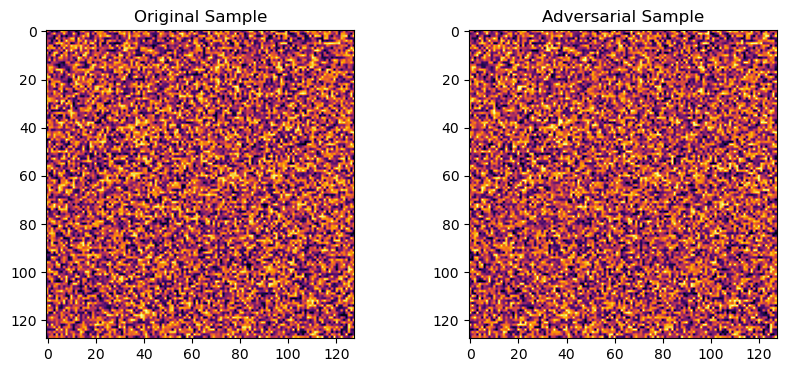

In [13]:
# Display Results
print(f"Original Prediction: {original_pred}, Adversarial Prediction: {adversarial_pred}")
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Sample")
plt.imshow(original_sample.squeeze(), cmap='inferno')
plt.subplot(1, 2, 2)
plt.title("Adversarial Sample")
plt.imshow(adversarial_sample.squeeze(), cmap='inferno')
plt.show()


NameError: name 'mel_spec_db' is not defined

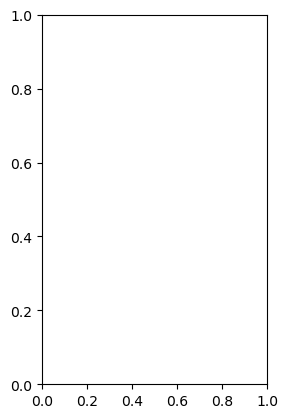

In [14]:
plt.subplot(1, 2, 1)
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Audio Spectrogram')

# Attacked Audio Spectrogram
plt.subplot(1, 2, 2)
librosa.display.specshow(attacked_mel_spec_db, sr=sr, x_axis='time', y_axis='mel', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Attacked Audio Spectrogram (FGSM)')

plt.tight_layout()
plt.show()